In [1]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import random
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

In [2]:
data = pd.read_csv('/kaggle/input/factors-affecting-campus-placement/Placement_Data_Full_Class.csv')

In [3]:
data.head()

,sl_no,gender,ssc_p,ssc_b,hsc_p,hsc_b,hsc_s,degree_p,degree_t,workex,etest_p,specialisation,mba_p,status,salary
0,1,M,67.00,Others,91.00,Others,Commerce,58.00,Sci&Tech,No,55.0,Mkt&HR,58.80,Placed,270000.0
1,2,M,79.33,Central,78.33,Others,Science,77.48,Sci&Tech,Yes,86.5,Mkt&Fin,66.28,Placed,200000.0
2,3,M,65.00,Central,68.00,Central,Arts,64.00,Comm&Mgmt,No,75.0,Mkt&Fin,57.80,Placed,250000.0
3,4,M,56.00,Central,52.00,Central,Science,52.00,Sci&Tech,No,66.0,Mkt&HR,59.43,Not Placed,NaN
4,5,M,85.80,Central,73.60,Central,Commerce,73.30,Comm&Mgmt,No,96.8,Mkt&Fin,55.50,Placed,425000.0


In [4]:
data.shape

(215, 15)

In [5]:
random.seed(42)

# Data:

215 college graduates with their grades from different stages of education and test, together with job placement outcomes.

## Column meaning:

	sl_no - Serial Number
    
    ssc_p - Secondary Education percentage- 10th Grade
    ssc_b - Board of Education- Central/ Others
    hsc_p - Higher Secondary Education percentage- 12th Grade  
    hsc_b - Board of Education- Central/ Others
    hsc_s - Specialization in Higher Secondary Education
    degree_p - Degree Percentage
    degree_t - Under Graduation(Degree type)- Field of degree education
    workex - Work Experience
    etest_p - Employability test percentage ( conducted by college)
    specialisation - Post Graduation(MBA)- Specialization
    mba_p - MBA percentage
    status - Status of placement- Placed/Not placed
    salary - Salary offered by corporate to candidates

# GOAL:
    examine gender gap
    predict job placement after college
    predict salary

## Explore columns, check missing values.
We will remove outliers when we will build the models.

In [6]:
# Label numerical and categorical columns
num_col = ['ssc_p', 'hsc_p', 'degree_p', 'etest_p', 'mba_p', 'salary']
cat_col = ['gender', 'ssc_b', 'hsc_b', 'hsc_s', 'degree_t', 'workex', 
           'specialisation', 'status']

In [7]:
data.groupby('gender').sl_no.count()

gender
F     76
M    139
Name: sl_no, dtype: int64

There are twice more males than females in the dataset. 

In [8]:
na_values = []
for column in data.columns:
    na_values.append(data[column].isna().sum())
print(na_values)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 67]


In [9]:
data[data.salary.isna()].status.unique()

array(['Not Placed'], dtype=object)

In [10]:
data[~data.salary.isna()].status.unique()

array(['Placed'], dtype=object)

We observe that the only missing values in the data are in the salary column. They correspond exactly to the non-placed candidates. We can fill the salary as 0. This will also make it harder to predict salary, since the dataset of people with salary consists of roughly 150 entries, which might not be enough for good model.

In [11]:
data.salary.fillna(0, inplace=True)

In [12]:
data[cat_col].describe()

,gender,ssc_b,hsc_b,hsc_s,degree_t,workex,specialisation,status
count,215,215,215,215,215,215,215,215
unique,2,2,2,3,3,2,2,2
top,M,Central,Others,Commerce,Comm&Mgmt,No,Mkt&Fin,Placed
freq,139,116,131,113,145,141,120,148


All categorical data seems intact, without strange or unexpected categories.

In [13]:
data[num_col].describe(percentiles=[0.1, 0.5, 0.9])

,ssc_p,hsc_p,degree_p,etest_p,mba_p,salary
count,215.000000,215.000000,215.000000,215.000000,215.000000,215.000000
mean,67.303395,66.333163,66.370186,72.100558,62.278186,198702.325581
std,10.827205,10.897509,7.358743,13.275956,5.833385,154780.926716
min,40.890000,37.000000,50.000000,50.000000,51.210000,0.000000
10%,52.000000,52.000000,57.000000,55.802000,54.986000,0.000000
50%,67.000000,65.000000,66.000000,71.000000,62.000000,240000.000000
90%,82.000000,79.000000,77.120000,92.000000,70.678000,356000.000000
max,89.400000,97.700000,91.000000,98.000000,77.890000,940000.000000


We see that there are some salary outliers (maximal is 940K, while 90% percentile is at 350K). The rest of the data seems balanced. (we can throw the outlier salaries later, when we train our model)

## Exploration of categorical columns

In [14]:
# We create a dataframe consisting only of placed workers, for which we will like to analyyze the salary.
placed = data[data.status=='Placed']

In [15]:
placed.salary.describe(percentiles=[0.25, 0.5, 0.75 ,0.95])

count       148.000000
mean     288655.405405
std       93457.452420
min      200000.000000
25%      240000.000000
50%      265000.000000
75%      300000.000000
95%      423250.000000
max      940000.000000
Name: salary, dtype: float64

In [16]:
# Introduce a new column indicating that a person is in top quartile of the salary.
placed.eval('top_sal = salary>300000', inplace=True)

Let us look at pairplot of the numerical values. The colors represent people with salary in top quartile, and the people in the bottom quartile.

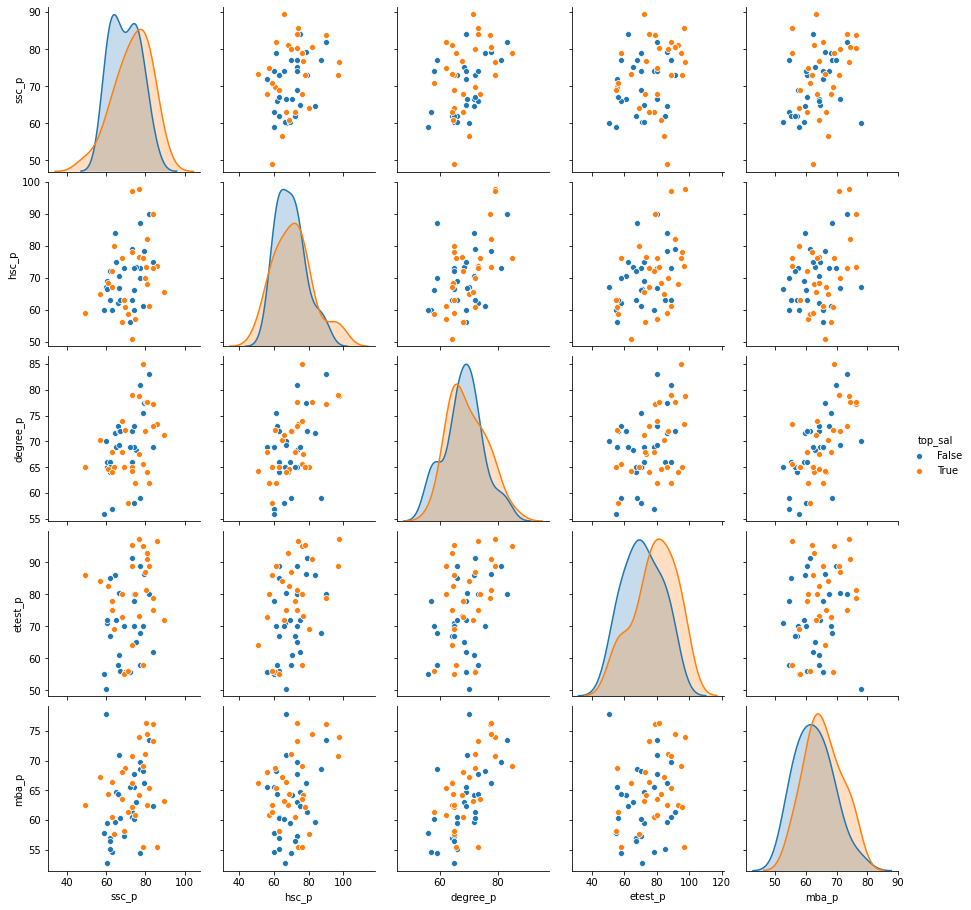

In [17]:
sns.pairplot(placed[(placed.salary>300000) | (placed.salary<240000)] [['ssc_p', 'hsc_p', 'degree_p', 'etest_p', 'mba_p', 'top_sal']], hue='top_sal')
plt.show()

In [18]:
# Correlation coefficients with top_sal and salary
placed[['ssc_p', 'hsc_p', 'degree_p', 'etest_p', 'mba_p', 'top_sal', 'salary']].corr()[['top_sal','salary']]

,top_sal,salary
ssc_p,0.092234,0.035330
hsc_p,0.061669,0.076819
degree_p,0.065317,-0.019272
etest_p,0.201410,0.178307
mba_p,0.256089,0.175013
top_sal,1.000000,0.737667
salary,0.737667,1.000000


We can see that even having top 25% salary does not correlate well with any of the numerical values, and salary even more so. This can be especially seen on pairplot graphs, as cadidates with top 25% salaries have their grades all over the place. Out of all grades, mba_p and etest seem to correlate the most with higher salaries.

Our first conclusion:
## Grades do not seem to influence the salary.
Hence, we will not pursue further the topic of salary and focus more on 

# Gender gap and job placement.

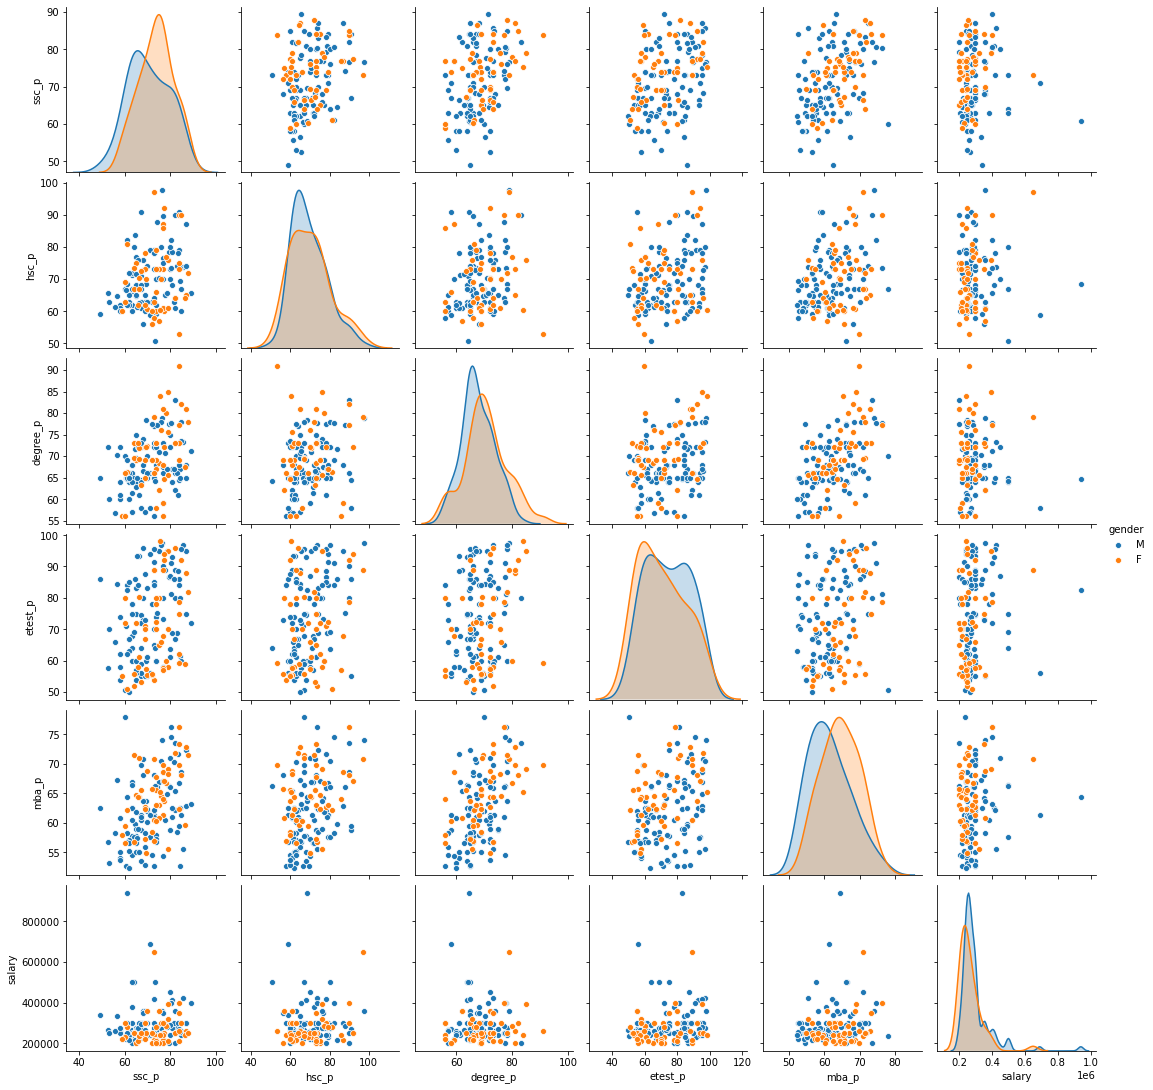

In [19]:
sns.pairplot(placed[['ssc_p', 'hsc_p', 'degree_p', 'etest_p', 'mba_p', 'gender', 'salary']], hue = 'gender')

Again, it does seem that the data is all over the place, and as expected. We can see that female grades are slightly better at ssc_p and degree_p and mba_p (which is supposed to correlate higher salaries), but the salary distribution is slightly worse for the women. This might seem counterintuitive, but may be explained by categorical values. Let us look at those.

In [20]:
data.eval('male = gender=="M" ', inplace=True)
data.eval('placed = status=="Placed" ', inplace=True)

In [21]:
data.male.mean()

0.6465116279069767

In [22]:
data.groupby('workex')['male', 'salary', 'placed'].mean().round(2)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


,male,salary,placed
workex,,,
No,0.62,165333.33,0.60
Yes,0.70,262283.78,0.86


We can see that men are more likely to have work experience, which might skew their salary, and partially explain why their average salary is higher.

In [23]:
data.groupby('degree_t')['male', 'salary', 'placed'].mean().round(2)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


,male,salary,placed
degree_t,,,
Comm&Mgmt,0.63,196000.00,0.70
Others,0.45,127454.55,0.45
Sci&Tech,0.71,218627.12,0.69


In [24]:
data.groupby('specialisation')['male', 'salary', 'placed'].mean().round(2)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


,male,salary,placed
specialisation,,,
Mkt&Fin,0.69,236591.67,0.79
Mkt&HR,0.59,150842.11,0.56


In [25]:
data.groupby('hsc_b')['male', 'salary', 'placed'].mean().round(2)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


,male,salary,placed
hsc_b,,,
Central,0.61,196476.19,0.68
Others,0.67,200129.77,0.69


What we see, that men are 65% of the data, in almost all above case, their percentage in higher paid group is higher than that.

Conclusion:
## Men are more represented in areas with higher average salaries.

We might be tempted to explain the gender gap by uneven representation. It is true that uneven representation does not help women, but let us control for some of those factors.

In [26]:
placed = placed[placed.salary<400000]  # remove outlier salaries

In [27]:
placed.groupby(['workex', 'gender'])['salary'].aggregate(['mean','median', 'count']).round(0)

mean    median  count
workex gender                           
No     F       256800.0  245000.0     30
       M       271292.0  265000.0     48
Yes    F       254750.0  250000.0     16
       M       270825.0  265000.0     40

In [28]:
placed.groupby(['specialisation', 'gender'])['salary'].aggregate(['mean','median', 'count']).round(0)

mean    median  count
specialisation gender                           
Mkt&Fin        F       260385.0  245000.0     26
               M       272155.0  266500.0     58
Mkt&HR         F       250500.0  250000.0     20
               M       269000.0  262500.0     30

In [29]:
placed.groupby(['degree_t', 'gender'])['salary'].aggregate(['mean','median', 'count']).round(0)

mean    median  count
degree_t  gender                           
Comm&Mgmt F       249613.0  240000.0     31
          M       268415.0  265000.0     65
Others    F       288000.0  276000.0      4
          M       250000.0  250000.0      1
Sci&Tech  F       262727.0  250000.0     11
          M       279909.0  272500.0     22

It seems like both mean and median for females is lower in almost all cases once we control for some categorical values, and also after we removed outliers with salaries above 400K (which were 90% men)

In [30]:
data[data.salary>400000].male.mean()

0.9

Categories degree_t and hsc_s seem to be very close, so I only chose one of them that seems more relevant for employmeny, ssc_b and hsc_b seem to not make much difference, so I ignored them.

Here is a breakdown of salaries by categories, that shows again that women are paid on average less in most categories:

In [31]:
placed.groupby(['workex', 'degree_t', 'specialisation',  'gender'])['salary'].aggregate(['mean','median', 'count']).round(0)

mean    median  count
workex degree_t  specialisation gender                           
No     Comm&Mgmt Mkt&Fin        F       270364.0  250000.0     11
                                M       267833.0  262000.0     24
                 Mkt&HR         F       233455.0  220000.0     11
                                M       264267.0  265000.0     15
       Others    Mkt&Fin        F       240000.0  240000.0      1
                 Mkt&HR         F       252000.0  252000.0      1
       Sci&Tech  Mkt&Fin        F       240000.0  240000.0      2
                                M       295000.0  272500.0      6
                 Mkt&HR         F       297500.0  290000.0      4
                                M       286667.0  270000.0      3
Yes    Comm&Mgmt Mkt&Fin        F       244500.0  243000.0      8
                                M       270000.0  265000.0     19
                 Mkt&HR         F       240000.0  240000.0      1
                                M       275000.0  260000.0      7
       Others    Mkt&Fin        F       360000.0  360000.0      1
                 Mkt&HR         F       300000.0  300000.0      1
                                M       250000.0  250000.0      1
       Sci&Tech  Mkt&Fin        F       253333.0  250000.0      3
                                M       273000.0  275000.0      9
                 Mkt&HR         F       230000.0  230000.0      2
                                M       267750.0  265500.0      4

Let us look at the most common category. 

In [32]:
most_common = data[(data.hsc_s=='Commerce') & (data.degree_t =='Comm&Mgmt')
                   & (data.workex=='No') & (data.specialisation=='Mkt&Fin') & (data.placed==True)]

In [33]:
most_common[['ssc_p', 'hsc_p', 'degree_p',  'etest_p', 'mba_p',
             'salary', 'male']].corr()[['salary', 'male']]

,salary,male
ssc_p,0.432034,-0.369891
hsc_p,0.091757,-0.436126
degree_p,0.534070,-0.218521
etest_p,0.506896,0.164602
mba_p,0.317899,-0.472740
salary,1.000000,-0.031724
male,-0.031724,1.000000


We see that now, salary is more corellated to grades (which makes sense), and while being male correlates strongly negatively with grades, it only slightly negatively correlates with salary. (males are likely to have lower grades but not lower salaries)

In [34]:
most_common[most_common.male==1][['ssc_p', 'hsc_p', 'degree_p',  'etest_p', 'mba_p',
             'salary']].corr().salary

ssc_p       0.418213
hsc_p       0.165574
degree_p    0.399731
etest_p     0.468667
mba_p       0.253416
salary      1.000000
Name: salary, dtype: float64

In [35]:
most_common[most_common.male==0][['ssc_p', 'hsc_p', 'degree_p',  'etest_p', 'mba_p',
             'salary']].corr().salary

ssc_p       0.614150
hsc_p      -0.162457
degree_p    0.799349
etest_p     0.649945
mba_p       0.618034
salary      1.000000
Name: salary, dtype: float64

We see that correlations with grades are much stronger for females than for males. Let us see this on pairplot.

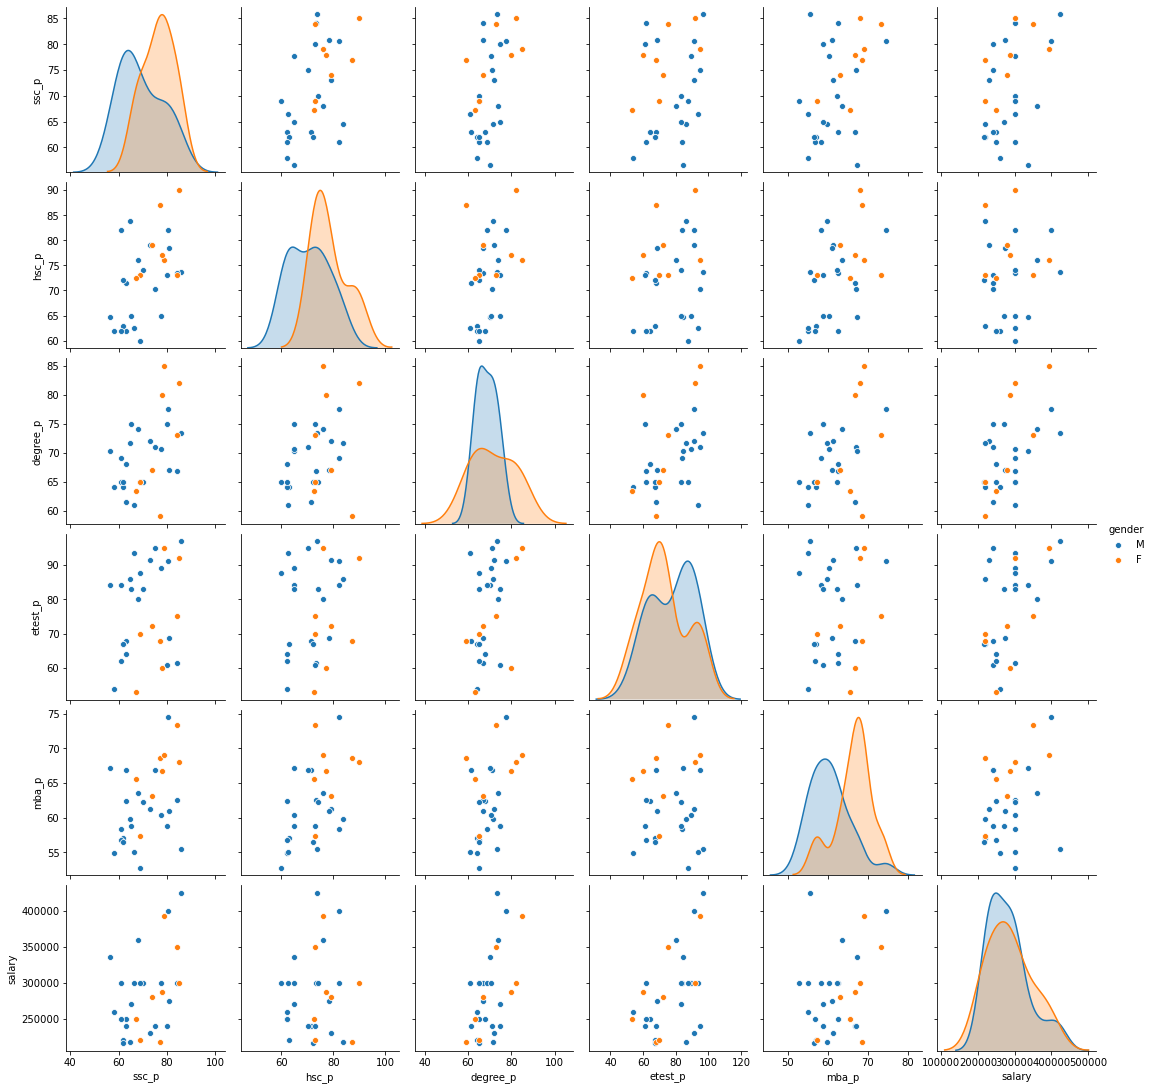

In [36]:
sns.pairplot(most_common[['ssc_p', 'hsc_p', 'degree_p','etest_p', 'mba_p', 'salary', 'gender']], hue='gender')
plt.show()

From the graphs in the last row, we can see that for people with same salary, females have higher ssc_p, hsc_p, degree_p and mba_p grades, while etest_p grades are mixed. 
## Grades matter much more for women to get higher salary (and seems like they need higher grades to get the same salary as men) 

Of course, our most_common dataset is very small, so this could be all noise, but here is one observation:

## Women seem to outperform men in all the grades except for etest. This raises a question whether something in the design of employability test favors men?


# Job placement

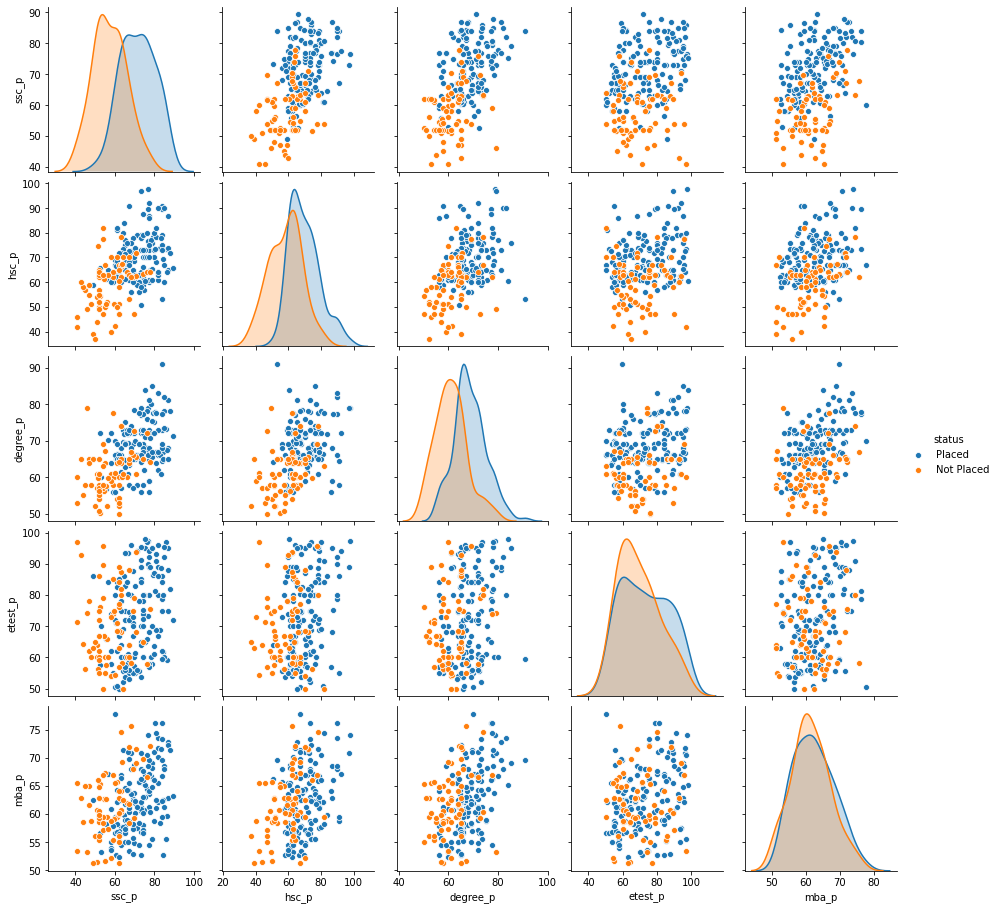

In [37]:
sns.pairplot(data[['ssc_p', 'hsc_p', 'degree_p','etest_p', 'mba_p', 'status']], hue='status')
plt.show()

We see that grades have good separation for job placement. etest_p and mba_p which were more correlated with higher salaries do not look to predict job placement well. 

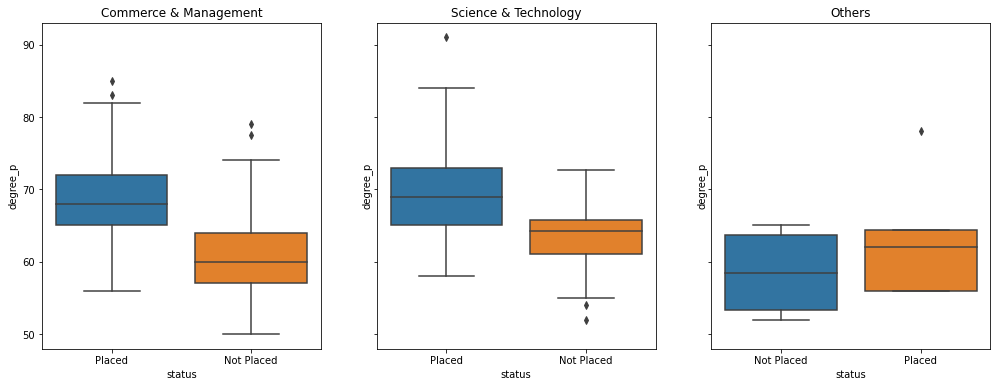

In [38]:
f, axes = plt.subplots(1, 3, sharey=True, figsize=(17,6))

sns.boxplot(x='status', y='degree_p', data=data[data.degree_t=='Comm&Mgmt'], ax=axes[0])
sns.boxplot(x='status', y='degree_p', data=data[data.degree_t=='Sci&Tech'], ax=axes[1])
sns.boxplot(x='status', y='degree_p', data=data[data.degree_t=='Others'], ax=axes[2])
axes[0].title.set_text('Commerce & Management')
axes[1].title.set_text('Science & Technology')
axes[2].title.set_text('Others')
plt.show()

We see that picking different specialisation (which probably correlates with picking college specialisation) matter for job placement, as people who specialised in arts get placed with lower range of grades (probably because they choose to go to jobs demanding less skills on which schools focus)

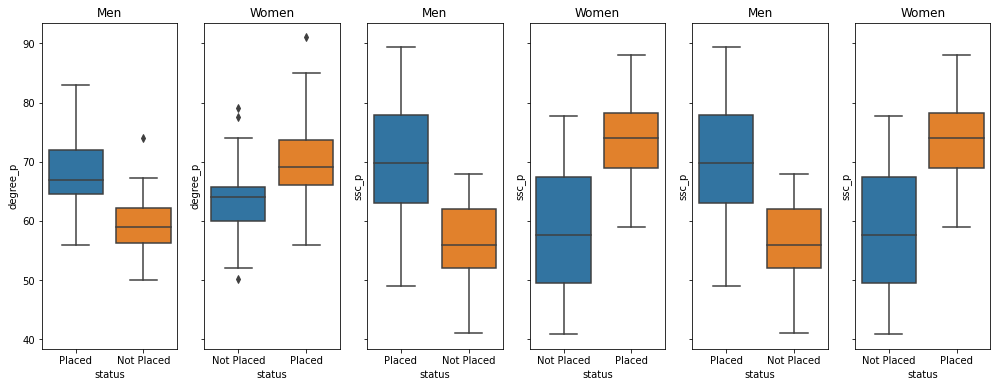

In [39]:
f, axes = plt.subplots(1, 6, sharey=True, figsize=(17,6))

sns.boxplot(x='status', y='degree_p', data=data[data.gender=='M'], ax=axes[0])
sns.boxplot(x='status', y='degree_p', data=data[data.gender=='F'], ax=axes[1])
sns.boxplot(x='status', y='ssc_p', data=data[data.gender=='M'], ax=axes[2])
sns.boxplot(x='status', y='ssc_p', data=data[data.gender=='F'], ax=axes[3])
sns.boxplot(x='status', y='ssc_p', data=data[data.gender=='M'], ax=axes[4])
sns.boxplot(x='status', y='ssc_p', data=data[data.gender=='F'], ax=axes[5])
axes[0].title.set_text('Men')
axes[1].title.set_text('Women')
axes[2].title.set_text('Men')
axes[3].title.set_text('Women')
axes[4].title.set_text('Men')
axes[5].title.set_text('Women')
plt.show()

Women with higher grades than men got rejected. Since women are more likely to be in areas that have lower pay, one would assume that they should have lower entry bar, but this is not the case. 

## The entry bar is higher for women

# Machine Learning

We will train a model to predict placement, based on the info. We will see the coefficients it assigns to the gender variable. 

Separately, we can train two ML models on datasets of men and women, and compare the coefficients they assign to different variables.

In [40]:
from sklearn.model_selection import train_test_split


In [41]:
data_one = pd.get_dummies(data[['gender', 'ssc_p', 'hsc_p', 
                                'hsc_s', 'degree_p', 'degree_t',
                                  'workex', 'etest_p', 'specialisation', 'mba_p']], drop_first=True)

In [42]:
y_one = data.placed

In [43]:
X_train, X_test, y_train, y_test = train_test_split(data_one, y_one, test_size=0.3, random_state=42)

In [44]:
# Accuracy of base estimator, just guessing that everyone is placed.
data.placed.mean()

0.6883720930232559

In [45]:
lr = LogisticRegression(penalty='l2',
    tol=0.001,
    C=50,
    random_state=42,
    solver='lbfgs',
    max_iter=1000,
    class_weight={1:1, 0:2})
lr.fit(X_train,y_train)
lr.score(X_train,y_train)

0.9266666666666666

In [46]:
lr.score(X_test,y_test)

0.8307692307692308

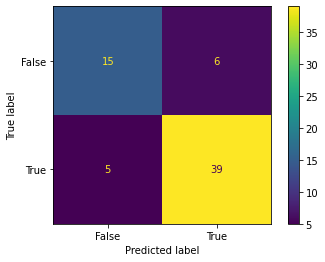

In [47]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(lr, X_test, y_test)
plt.show()

Logistic regression has 83% accuracy, better than our base estimator. Our model seems to be slightly optimistic, with the more common error being predicting that a person got placed, while in reality they weren't. This is common in unbalanced dataset. I tried to correct for that setting class weights in regression, according to the sizes of the groups of placed/non-placed.

In [48]:
coeff = list(zip(data_one.columns, lr.coef_[0].round(2)))

In [49]:
pd.DataFrame(coeff, columns=['variable', 'coefficent']).set_index('variable')

,coefficent
variable,
ssc_p,0.29
hsc_p,0.11
degree_p,0.24
etest_p,-0.02
mba_p,-0.32
gender_M,1.00
hsc_s_Commerce,-1.79
hsc_s_Science,-1.33
degree_t_Others,-0.74


There is something that might seem counterintuitive. The coefficients for hsc_s Commerce and Science are negative, while these areas have higher employability than Arts. However, as we saw before, one is required higher grades to be placed there. 

We see that gender_M coefficient is 1, while degee_p is 0.24. This means that according to our model
# Being female while trying to find a job is equivalent to having less 4 points in degree_p.

We can make a small experiment. Let us create two borderline candidates with the same grades but different genders.

In [50]:
# A borderline candidate with barely passing grades
female_candidate = [60  , 55  , 60  , 60  , 55,  0.  ,  1.  ,  0.  ,  0.  ,
        0.  ,  1.  ,  1.  ]
male_candidate = [60  , 55  , 60  , 60  , 55,  1  ,  1.  ,  0.  ,  0.  ,
        0.  ,  1.  ,  1.  ]

In [51]:
lr.predict_proba([female_candidate])

array([[0.58405775, 0.41594225]])

In [52]:
lr.predict_proba([male_candidate])

array([[0.33955619, 0.66044381]])

For borderline candidates with the same grades our model changes its prediction between being hired and not after changing the gender, with pretty big jump in probabilities. 

# Conclusions

The dataset is very small, so all conclusions should be taken with caution. It is hard to predict the salary from the grades. We saw that once we specialise to certain areas, the grades seem to correlate with salary, but there are obviously other factors not seen in the data, which affect the salary more than just the grades.

Having said this, it does seem that women with the same salaries as men in the same areas of specialisation have higher grades. They also need higher grades to get placed. Machine learning models (eventhough not very accurate) do quantify the gender gap.